数据预处理完成:
训练集: 特征=(16512, 8), 标签=(16512, 1)
测试集: 特征=(4128, 8), 标签=(4128, 1)
--------------------------------------------------
Epoch 1/50 | Train RMSE: 1.8471 | Test RMSE: 0.8141
Epoch 2/50 | Train RMSE: 0.8207 | Test RMSE: 0.8122
Epoch 3/50 | Train RMSE: 0.7729 | Test RMSE: 0.8234
Epoch 4/50 | Train RMSE: 0.7600 | Test RMSE: 0.8022
Epoch 5/50 | Train RMSE: 0.7467 | Test RMSE: 0.7414
Epoch 6/50 | Train RMSE: 0.7431 | Test RMSE: 0.7344
Epoch 7/50 | Train RMSE: 0.7348 | Test RMSE: 0.7312
Epoch 8/50 | Train RMSE: 0.7477 | Test RMSE: 0.7288
Epoch 9/50 | Train RMSE: 0.7386 | Test RMSE: 0.7312
Epoch 10/50 | Train RMSE: 0.7358 | Test RMSE: 0.7317
Epoch 11/50 | Train RMSE: 0.7324 | Test RMSE: 0.7290
Epoch 12/50 | Train RMSE: 0.7309 | Test RMSE: 0.7332
Epoch 13/50 | Train RMSE: 0.7331 | Test RMSE: 0.7269
Epoch 14/50 | Train RMSE: 0.7298 | Test RMSE: 0.7303
Epoch 15/50 | Train RMSE: 0.7469 | Test RMSE: 0.7277
Epoch 16/50 | Train RMSE: 0.7323 | Test RMSE: 0.7396
Epoch 17/50 | Train RMSE: 0.7415 | 

C:\Users\liu'zhi'gui\AppData\Local\Temp\ipykernel_54448\309949895.py:139: UserWarning: Glyph 36845 (\N{CJK UNIFIED IDEOGRAPH-8FED}) missing from font(s) DejaVu Sans.
  plt.tight_layout()   # 自动调整整体布局
C:\Users\liu'zhi'gui\AppData\Local\Temp\ipykernel_54448\309949895.py:139: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()   # 自动调整整体布局
C:\Users\liu'zhi'gui\AppData\Local\Temp\ipykernel_54448\309949895.py:139: UserWarning: Glyph 36718 (\N{CJK UNIFIED IDEOGRAPH-8F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()   # 自动调整整体布局
C:\Users\liu'zhi'gui\AppData\Local\Temp\ipykernel_54448\309949895.py:139: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()   # 自动调整整体布局
C:\Users\liu'zhi'gui\AppData\Local\Temp\ipykernel_54448\309949895.py:139: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  plt.tight_layout()   # 自动调整整体布局


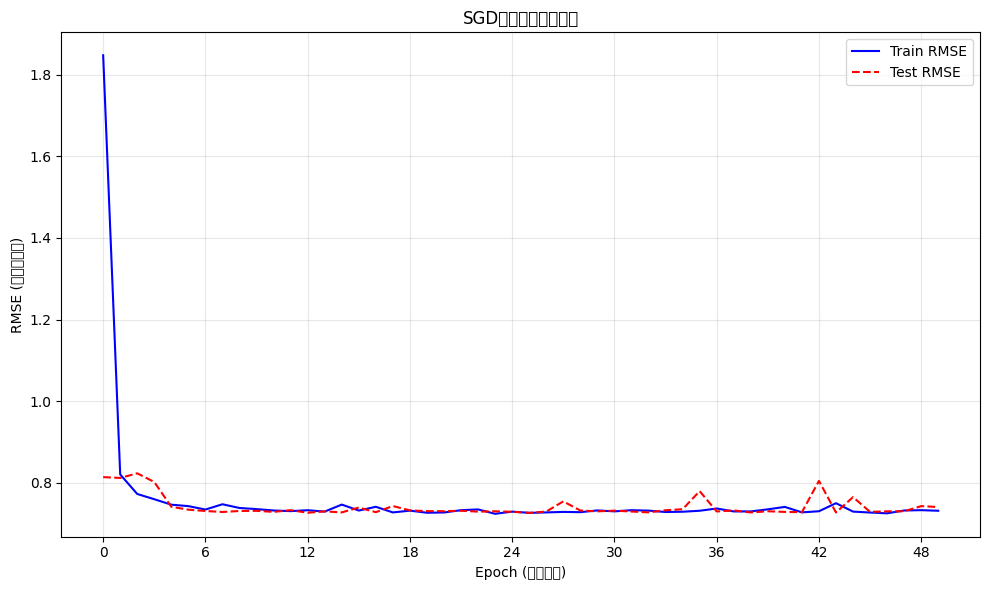

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# ------------------ 1. 工具函数：批量数据生成器 ------------------
def batch_generator(x, y, batch_size, shuffle=True):
    """
    生成随机批量数据 (用于SGD)
    :param x: 输入特征 (n_samples, n_features)
    :param y: 标签 (n_samples, 1)
    :param batch_size: 批量大小
    :param shuffle: 是否打乱数据
    :return: 批量生成器 (x_batch, y_batch)
    """
    n_samples = len(x)
    if shuffle:
        idx = np.random.permutation(n_samples)  # 随机打乱索引
        x = x[idx]
        y = y[idx]

    batch_count = 0
    while True:
        start = batch_count * batch_size
        end = min(start + batch_size, n_samples)
        if start >= end:
            break  # 遍历完所有数据，终止
        batch_count += 1
        yield x[start:end], y[start:end]

# ------------------ 2. 核心函数：随机梯度下降 (SGD) 回归 ------------------
def sgd_regression(x_train, y_train, x_test, y_test, num_epoch, learning_rate, batch_size):
    """
    使用SGD求解线性回归
    :param x_train, y_train: 训练数据
    :param x_test, y_test: 测试数据
    :param num_epoch: 迭代轮数
    :param learning_rate: 学习率
    :param batch_size: 批量大小
    :return: 回归系数 (含偏置)、训练损失、测试损失
    """
    # ---------- a. 数据预处理：拼接偏置项 (全1列) ----------
    # 给特征矩阵添加全1列 (用于学习偏置项theta0)
    X_train_bias = np.concatenate([x_train, np.ones((len(x_train), 1))], axis=1)
    X_test_bias = np.concatenate([x_test, np.ones((len(x_test), 1))], axis=1)

    # ---------- b. 初始化参数：theta (含偏置) ----------
    # theta形状: (n_features + 1, 1) -> 最后一项是偏置项
    theta = np.random.normal(size=X_train_bias.shape[1]).reshape(-1, 1)

    # ---------- c. 训练并记录损失 ----------
    train_losses = []  # 训练集RMSE
    test_losses = []   # 测试集RMSE

    for epoch in range(num_epoch):
        # 初始化批量生成器 (每轮重新打乱数据)
        batch_gen = batch_generator(X_train_bias, y_train, batch_size, shuffle=True)
        train_rmse_sum = 0  # 训练集总平方误差

        # 遍历所有批量，更新参数
        for x_batch, y_batch in batch_gen:
            # 计算预测值
            y_pred = x_batch @ theta
            # 计算梯度 (平均梯度，更稳定)
            grad = (x_batch.T @ (y_pred - y_batch)) / len(x_batch)
            # 更新参数
            theta -= learning_rate * grad

            # 累加训练损失 (平方和)
            train_rmse_sum += np.square(y_pred - y_batch).sum()

        # 计算本轮训练/测试RMSE
        train_rmse = np.sqrt(train_rmse_sum / len(X_train_bias))  # 训练集RMSE
        test_rmse = np.sqrt(np.square(X_test_bias @ theta - y_test).mean())  # 测试集RMSE
        train_losses.append(train_rmse)
        test_losses.append(test_rmse)

        # 打印每轮结果 (可选)
        print(f"Epoch {epoch+1}/{num_epoch} | Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")

    # 输出最终回归系数
    print("-" * 50)
    print(f"回归系数 (特征权重) : {theta[:-1].flatten()}")  # 前n_features位是特征权重
    print(f"偏置项 (theta0) : {theta[-1][0]:.4f}")      # 最后一位是偏置项
    print("-" * 50)

    return theta, train_losses, test_losses

# ==================== 3. 主程序：加载数据 + 运行SGD + 可视化 ====================
if __name__ == "__main__":
    # ---------- a. 加载并预处理数据 ----------
    # 加载加州房价数据集 (经典回归任务数据集)
    housing = fetch_california_housing()
    x = housing.data  # 特征 (8维: 收入、房龄、房间数等)
    y = housing.target.reshape(-1, 1)  # 标签 (房价中位数, 转为二维数组)

    # 标准化特征 (加速梯度下降收敛)
    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    # 划分训练集 (80%) 和测试集 (20%)
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=0  # random_state固定随机性
    )

    # 打印数据形状 (验证正确性)
    print("数据预处理完成:")
    print(f"训练集: 特征={x_train.shape}, 标签={y_train.shape}")
    print(f"测试集: 特征={x_test.shape}, 标签={y_test.shape}")
    print("-" * 50)

    # ---------- b. 设置超参数并运行SGD ----------
    num_epoch = 50          # 迭代轮数
    learning_rate = 0.01    # 学习率
    batch_size = 32         # 批量大小
    np.random.seed(0)       # 固定随机种子，结果可复现

    # 运行SGD回归
    theta, train_losses, test_losses = sgd_regression(
        x_train, y_train, x_test, y_test, num_epoch, learning_rate, batch_size
    )

    # ---------- c. 可视化损失曲线 ----------
    plt.figure(figsize=(10, 6))
    # 训练损失 (蓝色实线)
    plt.plot(np.arange(num_epoch), train_losses, color='blue', label='Train RMSE')
    # 测试损失 (红色虚线)
    plt.plot(np.arange(num_epoch), test_losses, color='red', linestyle='--', label='Test RMSE')

    # 图表美化
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # 横坐标为整数
    plt.xlabel('Epoch (迭代轮数)')
    plt.ylabel('RMSE (均方根误差)')
    plt.title('SGD线性回归损失曲线')
    plt.legend()
    plt.grid(alpha=0.3)  # 半透明网格
    plt.tight_layout()   # 自动调整整体布局

    # 保存图表 (可选)
    plt.savefig('sgd_regression_loss.png', dpi=300)
    plt.show()

最终回归系数: [ 0.82461146  0.10965629 -0.27161015  0.18415391 -0.01766535 -0.06744613
 -0.89164057 -0.88091583]
最终偏置项: 2.0727
最终测试集RMSE: 0.7409


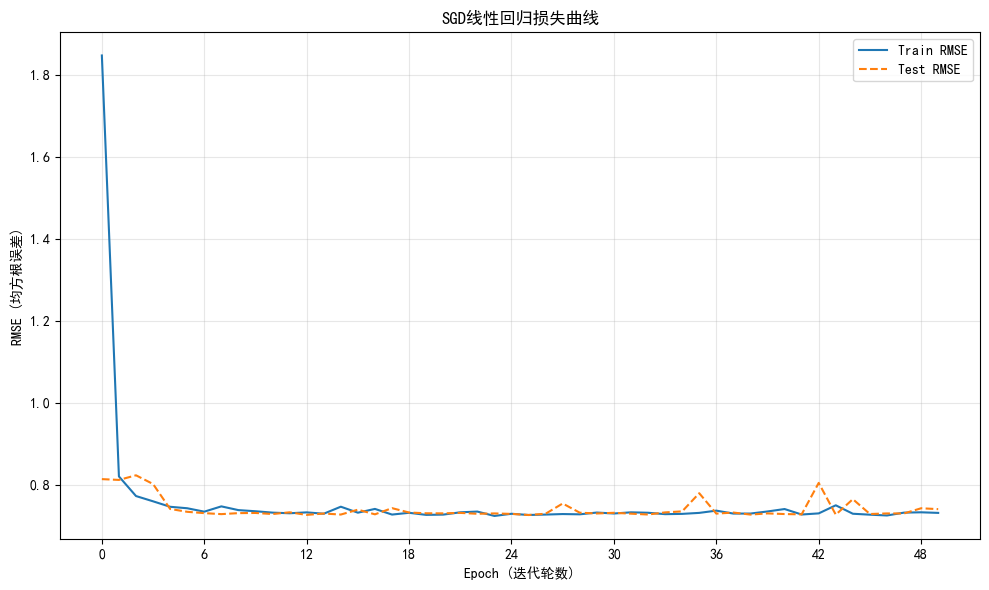

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

plt.rcParams['font.sans-serif'] = ['SimHei'] # 使用黑体
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号

def batch_generator(x, y, batch_size, shuffle=True):
    n_samples = len(x)
    if shuffle:
        idx = np.random.permutation(n_samples)
        x = x[idx]
        y = y[idx]

    batch_count = 0
    while True:
        start = batch_count * batch_size
        end = min(start + batch_size, n_samples)
        if start >= end:
            break
        batch_count += 1
        yield x[start:end], y[start:end]

def sgd_regression(x_train, y_train, x_test, y_test, num_epoch, learning_rate, batch_size):
    X_train_bias = np.concatenate([x_train, np.ones((len(x_train), 1))], axis=1)
    X_test_bias = np.concatenate([x_test, np.ones((len(x_test), 1))], axis=1)
    
    theta = np.random.normal(size=X_train_bias.shape[1]).reshape(-1, 1)
    
    train_losses = []
    test_losses = []

    for epoch in range(num_epoch):
        batch_gen = batch_generator(X_train_bias, y_train, batch_size, shuffle=True)
        train_rmse_sum = 0

        for x_batch, y_batch in batch_gen:
            y_pred = x_batch @ theta
            grad = (x_batch.T @ (y_pred - y_batch)) / len(x_batch)
            theta -= learning_rate * grad
            train_rmse_sum += np.square(y_pred - y_batch).sum()

        train_rmse = np.sqrt(train_rmse_sum / len(X_train_bias))
        test_rmse = np.sqrt(np.square(X_test_bias @ theta - y_test).mean())
        train_losses.append(train_rmse)
        test_losses.append(test_rmse)
        
    return theta, train_losses, test_losses

if __name__ == "__main__":
    # 1. 设置超参数
    num_epoch = 50
    learning_rate = 0.01
    batch_size = 32
    np.random.seed(0)

    # 2. 加载和准备数据
    housing = fetch_california_housing()
    x, y = housing.data, housing.target.reshape(-1, 1)
    x = StandardScaler().fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

    # 3. 运行SGD回归并获取结果
    theta, train_losses, test_losses = sgd_regression(
        x_train, y_train, x_test, y_test, num_epoch, learning_rate, batch_size
    )

    # 4. 打印最终模型参数
    print(f"最终回归系数: {theta[:-1].flatten()}")
    print(f"最终偏置项: {theta[-1][0]:.4f}")
    print(f"最终测试集RMSE: {test_losses[-1]:.4f}")

    # 5. 可视化损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(num_epoch), train_losses, label='Train RMSE')
    plt.plot(np.arange(num_epoch), test_losses, label='Test RMSE', linestyle='--')
    
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Epoch (迭代轮数)')
    plt.ylabel('RMSE (均方根误差)')
    plt.title('SGD线性回归损失曲线')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    